In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
#from celluloid import Camera
import matplotlib.cm as cm
from scipy import constants
from fplanck import fokker_planck, boundary, gaussian_pdf

def curve2(r,sigma,mu): 
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2*sigma**2))

def solutiontoFPE(x,D,dt):
    return 1/np.sqrt(4*np.pi*D*dt)*np.exp(-x**2/(4*D*dt))

Area FPE - fplanck = 1.0000000000000004
Area FPE - my one = 0.9999999999999993
Area Theory = 1.0000000000000002


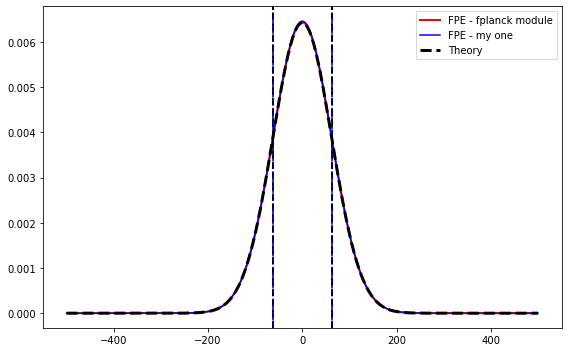

In [140]:
D_0 = 3.85e-14

boundaryradius = 5e-7   #Size of the arena
nx = 201
nt = 200
totaltime = 0.05
delta_x = 2*boundaryradius/nx
delta_t = totaltime/nt
Darray = D_0 * np.ones(nx)
xarray = np.linspace(-boundaryradius,boundaryradius,nx)

G = delta_t/delta_x**2

M = np.zeros((nx,nx))
for i in range(1,nx):
    M[i,i] = 1+G*(3*Darray[i]-Darray[i-1])
    M[i,i-1] = -G*Darray[i-1] 
    M[i-1,i] = G*(Darray[i-1]-2*Darray[i])
M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
M[0,1] = M[-1,-2] = -1
#M = np.zeros((nx,nx))
#for i in range(1,nx):
#    M[i,i] = 1+2*G*D_0
#    M[i,i-1] = M[i-1,i] = -G*D_0
#M[0,0] = M[-1,-1] = 1   #Neumann boundary condition  c[0,:] = c[-1,:] = 0
#M[0,1] = M[-1,-2] = -1

unew = np.zeros((nx,nt))        #array to save the density distributions
position = int(100)
unew[position,0] = 1/delta_x
for i in range(1,nt):
    b = unew[:,i-1]
    b[0] = 0
    b[-1] = 0#b[1]
    csingle = np.linalg.solve(M,b)
    unew[:,i] = csingle/sum(abs(csingle)*delta_x)  
    
uforv = np.zeros(nx)
uforv = unew[:,-1]/sum(unew[:,-1])
var = 0
for i in range(1,nx-1): var += (xarray[i]-xarray[position])**2*uforv[i]
std = np.sqrt(var)

nm = 1e-9
T = 300
drag = constants.k*T/D_0 #6*np.pi*viscosity*radius
sim = fokker_planck(temperature=T, drag=drag, extent=2*boundaryradius,resolution=delta_x, boundary=boundary.periodic)

### time-evolved solution
w = 1e-9#*nm
pdf = gaussian_pdf(0, w)
p0 = pdf(sim.grid[0])
time, Pt = sim.propagate_interval(pdf, totaltime, nt)
dxFPE = (sim.grid[0,1]-sim.grid[0,0])/nm
PDF = np.zeros(len(Pt[-1,:]))
PDF = Pt[-1,:]
PDF /= sum(PDF)*dxFPE

fig=plt.figure(1, figsize = (8,5) )
plt.subplot(1,1,1)

plt.plot(sim.grid[0]/nm, PDF, lw=2, color='red',label = 'FPE - fplanck module')
print('Area FPE - fplanck = '+str(sum(PDF)*dxFPE))

plt.plot(xarray*1e9,unew[:,-1]*1e-9,label = 'FPE - my one',color='blue')
for i in [-1,1]: plt.axvline(x=i*std*1e9,color='blue',linewidth=2,linestyle='--') 
print('Area FPE - my one = '+str(sum(unew[:,-1])*delta_x))

theory = solutiontoFPE(xarray,D_0,totaltime)
theory /= sum(theory)*delta_x_calc
plt.plot(xarray*1e9,theory,lw=3,linestyle='--',color='k',label = 'Theory')
for i in [-1,1]: plt.axvline(x=i*np.sqrt(2*D_0*totaltime)*1e9,color='k',linestyle='--')
print('Area Theory = '+str(sum(theory)*delta_x_calc))
  
#plt.xlim([xarray[position]-0.5e-6,xarray[position]+0.5e-6])
#plt.ylim([0,1.5e7])
plt.legend()
plt.tight_layout()
#plt.savefig(str(name)+'.svg', format='svg')
plt.show()

u = np.zeros((nx,nt)) 
u = unew[:,:]
x = np.linspace(-boundaryradius,boundaryradius,nx)

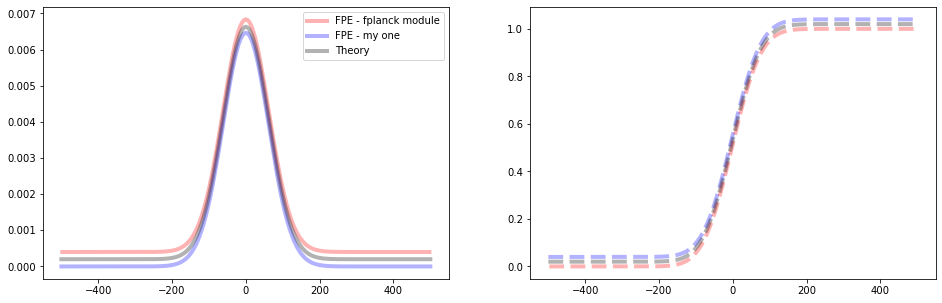

4.975124378109502
4.975124378109452
4.999999999999952


In [142]:
lenPDF = len(PDF)
checkPDFfplanck = np.zeros((lenPDF,3))
checkPDFfplanck[0,0] = sim.grid[0,0]/nm
checkPDFfplanck[0,1] = PDF[0]
checkPDFfplanck[0,2] = PDF[0]*dxFPE
for i in range(1,lenPDF):
    checkPDFfplanck[i,0] = sim.grid[0,i]/nm
    checkPDFfplanck[i,1] = PDF[i]
    checkPDFfplanck[i,2] = checkPDFfplanck[i-1,2] + PDF[i]*dxFPE

checkPDFmy = np.zeros((nx,3))
checkPDFmy[0,0] = xarray[0]*1e9
checkPDFmy[0,1] = unew[0,-1]*1e-9
checkPDFmy[0,2] = unew[0,-1]*delta_x
for i in range(1,nx):
    checkPDFmy[i,0] = xarray[i]*1e9
    checkPDFmy[i,1] = unew[i,-1]*1e-9
    checkPDFmy[i,2] = checkPDFmy[i-1,2] + unew[i,-1]*delta_x

checktheory = np.zeros((nx,3))
checktheory[0,0] = xarray[0]*1e9
checktheory[0,1] = theory[0]*1e-9
checktheory[0,2] = theory[0]*delta_x_calc
for i in range(1,nx):
    checktheory[i,0] = xarray[i]*1e9
    checktheory[i,1] = theory[i]
    checktheory[i,2] = checktheory[i-1,2] + theory[i]*delta_x_calc

fig=plt.figure(1, figsize = (16,5) )
plt.subplot(1,2,1)
plt.plot(checkPDFfplanck[:,0],checkPDFfplanck[:,1]+0.0004,c='red',label='FPE - fplanck module',alpha=0.3,linewidth = 4)
plt.plot(checkPDFmy[:,0],checkPDFmy[:,1],c='blue',label='FPE - my one',alpha=0.3,linewidth = 4)
plt.plot(checktheory[:,0],checktheory[:,1]+0.0002,c='k',label='Theory',alpha=0.3,linewidth = 4)
plt.legend()

plt.subplot(1,2,2)
plt.plot(checkPDFmy[:,0],checkPDFmy[:,2]+0.04,c='blue',linestyle='--',alpha=0.3,linewidth = 4)
plt.plot(checkPDFfplanck[:,0],checkPDFfplanck[:,2],c='red',linestyle='--',alpha=0.3,linewidth = 4)
plt.plot(checktheory[:,0],checktheory[:,2]+0.02,c='k',linestyle='--',alpha=0.3,linewidth = 4)
plt.show()

print(dxFPE)
print(delta_x*1e9)
print(delta_x_calc)

-5e-07
[-5.00e-07 -4.95e+02 -4.90e+02 -4.85e+02 -4.80e+02 -4.75e+02 -4.70e+02
 -4.65e+02 -4.60e+02 -4.55e+02]


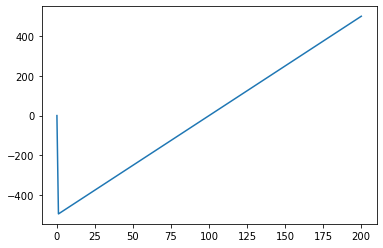

In [115]:
plt.plot(checkPDFmy[:,0])
print(xarray[0])
print(checkPDFmy[:10,0])

1.0


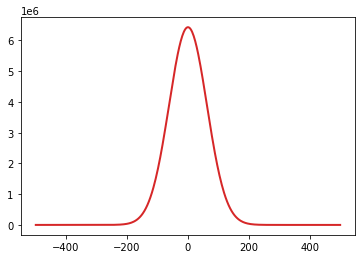

In [54]:
dxFPE = (sim.grid[0,1]-sim.grid[0,0])/nm
PDF = np.zeros(len(Pt[-1,:]))
PDF = Pt[-1,:]
PDF /= sum(PDF)*dxFPE
plt.plot(sim.grid[0]/nm, PDF*1e9, lw=2, color='C3')
print(sum(PDF)*dxFPE)

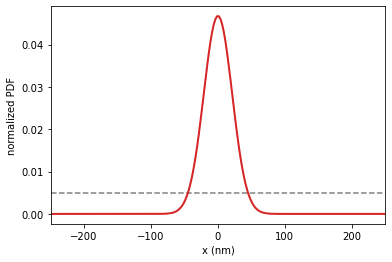

In [10]:
nm = 1e-9
T = 300
drag = constants.k*T/D_0 #6*np.pi*viscosity*radius

sim = fokker_planck(temperature=T, drag=drag, extent=500*nm,resolution=delta_x, boundary=boundary.periodic)

### steady-state solution
steady = sim.steady_state()

### time-evolved solution
w = 30*nm
pdf = gaussian_pdf(0, w)
p0 = pdf(sim.grid[0])

time, Pt = sim.propagate_interval(pdf, totaltime, nt)

### animation
fig, ax = plt.subplots()

ax.plot(sim.grid[0]/nm, steady, color='k', ls='--', alpha=.5)
ax.plot(sim.grid[0]/nm, p0, color='red', ls='--', alpha=.3)
line, = ax.plot(sim.grid[0]/nm, p0, lw=2, color='C3')

def update(i):
    line.set_ydata(Pt[i])
    return [line]

name = 'Free space'
anim = FuncAnimation(fig, update, frames=range(nt), interval=30)
ax.set(xlabel='x (nm)', ylabel='normalized PDF')
ax.margins(x=0)
#anim.save(str(name)+".mp4")
plt.show()